<a href="https://colab.research.google.com/github/mrb-haqee/Machine_learning_project/blob/main/Image_Classification_(Math_numbers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nama : Muhammad Rafli Baihaqi

# Submission: Image Classification

In [1]:
!pip install tensorflow
!pip install livelossplot
!pip install opendatasets

In [78]:
# @title Import Library

import cv2
from os import listdir, makedirs, remove
from os.path import join, exists, isdir
from IPython.display import clear_output

from google.colab import files
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from livelossplot import PlotLossesKeras
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Download dataset
Link: https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols


>**Penting: unduh file kaggle.json pada pada akun kaggle anda**

In [3]:
# @title Download dataset

user_response = input("Upload file kaggle.json? [yes]\n")
if user_response == 'yes' or user_response == '':
    uploaded = files.upload()

od.download("https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols")

Upload file kaggle.json? [yes]



Saving kaggle.json to kaggle.json


100%|██████████| 39.4M/39.4M [00:00<00:00, 101MB/s] 


# Prepare Dataset

In [4]:
# @title function helper
def get_data(path_dataset, category):
  image_paths = []
  categories = []
  for filename in listdir(join(path_dataset, category)):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):  # Sesuaikan dengan ekstensi gambar Anda
        # Path lengkap ke gambar
        image_path = join(category, filename)

        # Menambahkan path dan kategori ke list
        image_paths.append(image_path)
        categories.append(category)
  return image_paths,categories

In [5]:
# @title membuat DataFrame

path_dataset = '/content/handwritten-math-symbols/dataset'

if exists(join(path_dataset, '.directory')):
    remove(join(path_dataset, '.directory'))

classes = listdir(path_dataset)

image_paths = list()
categories = list()

for name in classes:
    path, name = get_data(path_dataset, name)
    image_paths  += path
    categories  += name

df_dataset = pd.DataFrame({
    'image_path':image_paths,
    'category':categories
})
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10071 entries, 0 to 10070
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10071 non-null  object
 1   category    10071 non-null  object
dtypes: object(2)
memory usage: 157.5+ KB


In [55]:
df_dataset.groupby('category').count()

,image_path
category,
0,595
1,562
2,433
3,541
4,526
5,433
6,581
7,533
8,554


In [61]:
df = df_dataset.sort_values(by='category').reset_index(drop=True)

category=pd.get_dummies(df.category)
df=pd.concat([df, category], axis=1)
df=df.drop(columns='category')
df

,image_path,0,1,2,3,4,5,6,7,8,9,add,dec,div,eq,mul,sub,x,y,z
0,0/98154.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0/83407.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0/TLgalDV6.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0/27948.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0/BZvdQBrV.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10066,z/u6NzZFpG.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10067,z/8q61vioN.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10068,z/X6YU683s.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10069,z/w28GKIvo.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Data Processing

In [62]:
# @title Image processing
input_shape = (64, 64, 3)

def preprocessing_img(path_image) :
    images = []

    for i, path in enumerate(path_image):
        img = cv2.imread(join(path_dataset, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=input_shape[:2])
        images.append(img)
        if (i/1000).is_integer():
          print(f'{int(len(path_image)/1000) - int(i/1000)}k data lagi....')
          clear_output(wait=True)
    print("Proses Selesai!")
    return np.array(images)

In [63]:
path_image = df['image_path'].values
label = df[df.columns[1:]].values

image_pre = preprocessing_img(path_image)

X_train, X_test, y_train, y_test = train_test_split(image_pre, label, test_size=0.2)

Proses Selesai!


In [69]:
# @title Normalisasi dan Augmentasi Data
batch_size=64

train_set = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.5, 1.3],
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest'
).flow(
    X_train,
    y_train
)

test_set = ImageDataGenerator(
    rescale=1./255,
).flow(
    X_test,
    y_test
)

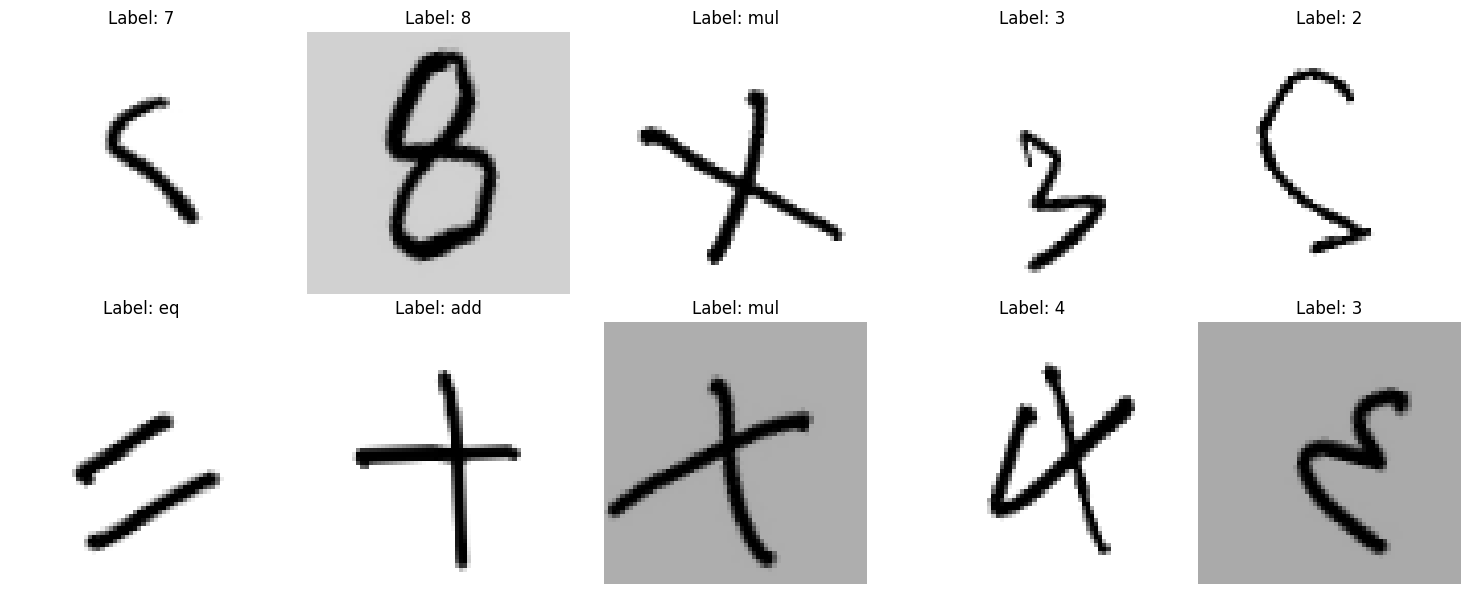

In [70]:
# @title Display Image

category = df.columns[1:].values

n = 10
rows = int(n / 5) if n % 5 == 0 else int(n / 5) + 1
cols = 5 if n > 5 else n

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i in range(n):
    image, label = train_set.next()
    ax = axes[i // cols, i % cols] if n > 1 else axes
    ax.imshow(image[0])
    ax.set_title(f"Label: {category[np.argmax(label[0])]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Training

In [71]:
# @title Callbacks

acu = 0.95

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy > acu and val_accuracy > acu:
            print(f"\nAkurasi telah mencapai lebih dari {acu * 100}% pada epoch {epoch + 1}!")
            self.model.stop_training = True
        else:
            print(f"\nEpoch {epoch + 1} - Akurasi Pelatihan: {train_accuracy:.4f}, Akurasi Validasi: {val_accuracy:.4f}")


callbacks = MyCallback()
checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [72]:
# @title CNN Arsitektur
output = len(df.columns[1:].values)

K.clear_session()
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(output, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30, 30, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0

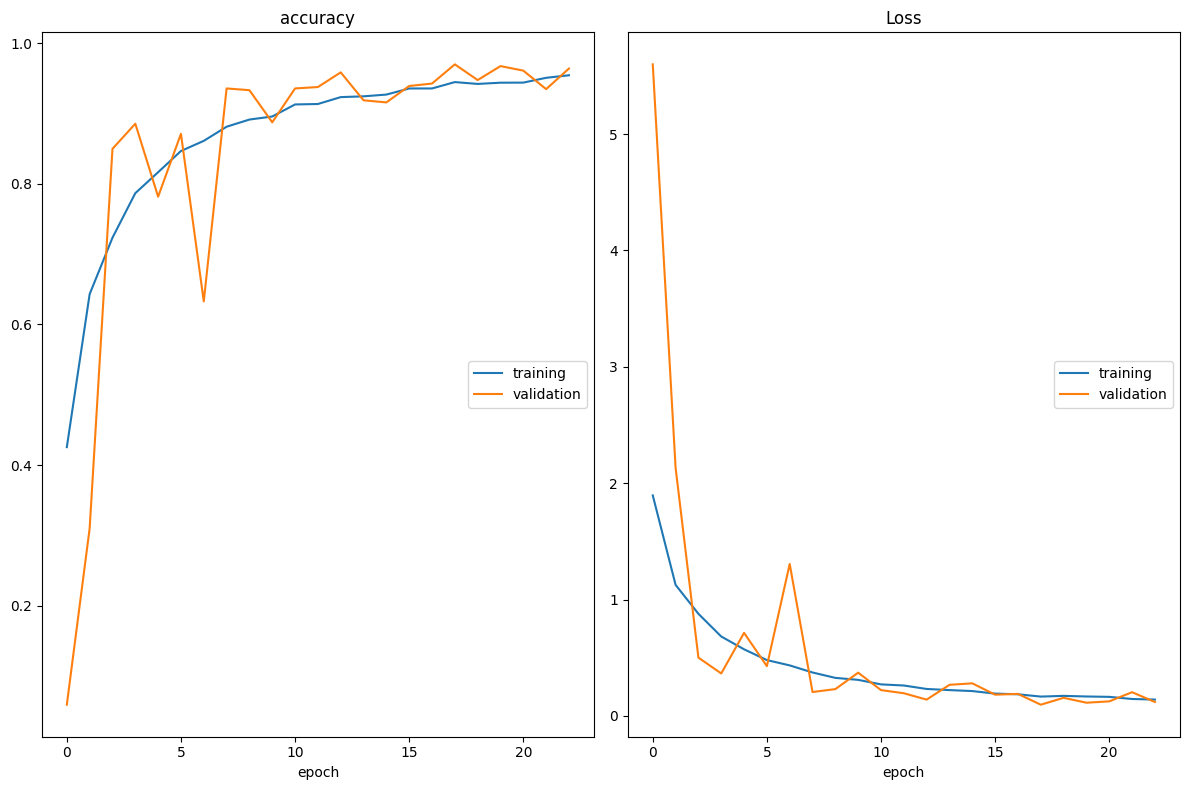

accuracy
	training         	 (min:    0.426, max:    0.954, cur:    0.954)
	validation       	 (min:    0.060, max:    0.970, cur:    0.964)
Loss
	training         	 (min:    0.141, max:    1.895, cur:    0.141)
	validation       	 (min:    0.097, max:    5.600, cur:    0.120)

Akurasi telah mencapai lebih dari 95.0% pada epoch 23!

Epoch 23: val_accuracy did not improve from 0.96973
252/252 [==============================] - 17s 68ms/step - loss: 0.1410 - accuracy: 0.9542 - val_loss: 0.1202 - val_accuracy: 0.9638


In [73]:
# @title training Models
epochs = 50

history = model.fit(
    train_set,
    epochs=epochs,
    # batch_size=batch_size,
    validation_data=test_set,
    callbacks=[
            PlotLossesKeras(),
            callbacks,
            checkpoint,
        ],
)

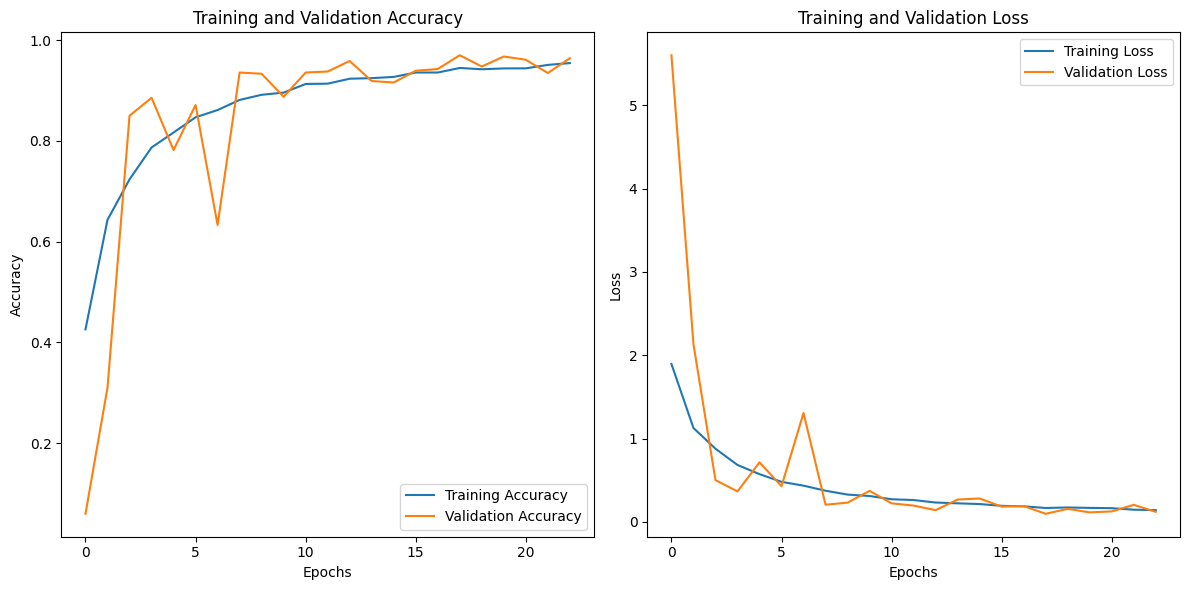

In [74]:
# @title Plot
# Nilai loss dan akurasi dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot akurasi
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()

In [75]:
# @title load model
model_load = load_model('./model.keras')

model_load.evaluate(test_set)

63/63 [==============================] - 1s 8ms/step - loss: 0.0970 - accuracy: 0.9697


[0.09695085138082504, 0.9697270393371582]

# Testing Model

In [76]:
def predict_uploaded_image(model, path, category):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    origin_img = cv2.resize(img, (224,224))
    img = cv2.resize(img, input_shape[:2])
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    predicted_class = model.predict(img)
    class_labels = category
    predicted_label = class_labels[np.argmax(predicted_class)]

    print(f"Prediksi: {predicted_label}")
    plt.imshow(origin_img)
    plt.axis('off')
    plt.show()

print(f"category yang dipilih: \n{df.columns[1:].values}")

category yang dipilih: 
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'add' 'dec' 'div' 'eq' 'mul'
 'sub' 'x' 'y' 'z']


1/1 [==============================] - 0s 127ms/step
Prediksi: x


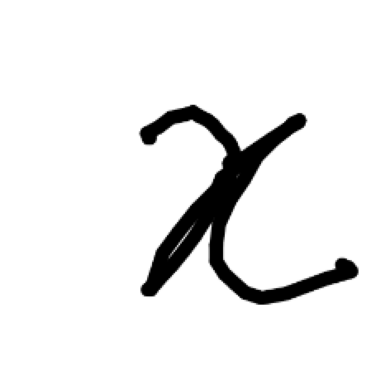

In [77]:
sample_path = '/content/handwritten-math-symbols/dataset/x/0N69wLku.png'

category = df.columns[1:].values
predict_uploaded_image(model_load, sample_path, category)

# Save model ke dalam format TF-Lite

In [50]:
import tensorflow as tf
import pathlib

export_dir = 'saved_model/'
pathlib.Path(export_dir).mkdir(parents=True, exist_ok=True)

tf.saved_model.save(model_load, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

9030920